In [1]:
import sklearn.datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
import pandas as pd
import numpy as np
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import expit
import requests
from IPython.display import display, HTML

import sys
from pathlib import Path

# Load and prep Data

In [ ]:
# to download the dataset directly use:
# https://github.com/Kaggle/kaggle-api
# or
# see approaches here https://stackoverflow.com/questions/45261190/how-to-get-kaggle-competition-data-via-command-line-on-virtual-machine

# Note: 'https://www.kaggle.com/tunguz/internet-firewall-data-set/download' sends you to a GUI login page, so it is necessary to provide credentials

In [2]:
data_dir = '/private/tmp'

In [4]:
# see for kaggle CLI install instructions and set up API credentials: https://github.com/Kaggle/kaggle-api
!kaggle datasets download tunguz/internet-firewall-data-set -p $data_dir --unzip

  0%|                                                | 0.00/754k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 754k/754k [00:00<00:00, 11.7MB/s]


In [5]:
# https://www.kaggle.com/tunguz/internet-firewall-data-set/download
path = Path(data_dir, 'log2.csv')
df = pd.read_csv(path)
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [ ]:
# Data notes: all numeric continuous features

In [6]:
# prep and split data

y = df['Action']
X = df.drop('Action',axis=1)

print('feat dims:', X.shape)
print('target class counts:')
display(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

feat dims: (65532, 11)
target class counts:


allow         37640
deny          14987
drop          12851
reset-both       54
Name: Action, dtype: int64

# Fit and Evaluate Models

## Sklearn Random Forest

In [13]:
# Train predictive model

cls_skl = RandomForestClassifier(max_depth=3, n_estimators=100, random_state=0)
cls_skl.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, random_state=0)

In [14]:
# evaluate model performance

cls = cls_skl
proba_preds = cls.predict_proba(X_test)
preds = cls.classes_[proba_preds.argmax(axis=1)]

pd.DataFrame(classification_report(y_test, preds, output_dict=True))
# near perfect accuracy # (xgboost is better with the tiny minority class)



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,allow,deny,drop,reset-both,accuracy,macro avg,weighted avg
precision,0.999360,0.992318,0.994431,0.0,0.996765,0.746527,0.996163
recall,0.997764,0.994161,1.000000,0.0,0.996765,0.747981,0.996765
f1-score,0.998561,0.993239,0.997208,0.0,0.996765,0.747252,0.996462
support,9391.000000,3768.000000,3214.000000,10.0,0.996765,16383.000000,16383.000000


## XGBoost

In [15]:
cls_xgb = XGBClassifier(n_estimators=400, max_depth=3, min_child_weight=10)
cls_xgb.fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:12:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=10, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [16]:
# evaluate model performance

cls = cls_xgb
proba_preds = cls.predict_proba(X_test)
preds = cls.classes_[proba_preds.argmax(axis=1)]

pd.DataFrame(classification_report(y_test, preds, output_dict=True))
# near perfect accuracy # (xgboost is better with the tiny minority class)


,allow,deny,drop,reset-both,accuracy,macro avg,weighted avg
precision,1.000000,0.997347,0.997517,1.000000,0.998901,0.998716,0.998903
recall,0.999574,0.997877,1.000000,0.400000,0.998901,0.849363,0.998901
f1-score,0.999787,0.997612,0.998757,0.571429,0.998901,0.891896,0.998823
support,9391.000000,3768.000000,3214.000000,10.000000,0.998901,16383.000000,16383.000000


## Sklearn SVM

In [27]:



cls_svm = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='rbf', probability=True))
cls_svm.fit(X_train, y_train)

# sloooow compared to RF and XGB!!! probably because the one-vs-one multiclass approach (also further much extended bc probability=True which does 5-fold cv for each ?class?)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', probability=True))])

In [28]:
cls = cls_svm
preds = cls.predict(X_test)
# cls.predict_proba(X_test) # n_samples x n_classes

pd.DataFrame(classification_report(y_test, preds, output_dict=True))

# worst predictive capacity

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,allow,deny,drop,reset-both,accuracy,macro avg,weighted avg
precision,0.999358,0.990000,0.962275,0.0,0.989684,0.737908,0.989321
recall,0.994250,0.972134,1.000000,0.0,0.989684,0.741596,0.989684
f1-score,0.996797,0.980986,0.980775,0.0,0.989684,0.739639,0.989409
support,9391.000000,3768.000000,3214.000000,10.0,0.989684,16383.000000,16383.000000


## Sklearn Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression

cls_log = make_pipeline(StandardScaler(), LogisticRegression(penalty='none', multi_class='ovr', max_iter=1000))#, solver='sag'))
cls_log.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, multi_class='ovr',
                                    penalty='none'))])

In [8]:
cls = cls_log
proba_preds = cls.predict_proba(X_test)
preds = cls.classes_[proba_preds.argmax(axis=1)]

pd.DataFrame(classification_report(y_test, preds, output_dict=True))

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,allow,deny,drop,reset-both,accuracy,macro avg,weighted avg
precision,0.999361,0.995377,0.968364,0.0,0.992187,0.740775,0.991754
recall,0.998935,0.971338,1.000000,0.0,0.992187,0.742568,0.992187
f1-score,0.999148,0.983210,0.983928,0.0,0.992187,0.741571,0.991887
support,9391.000000,3768.000000,3214.000000,10.0,0.992187,16383.000000,16383.000000


# Calculate Shap Feature Importances

##  Sklearn Random Forest

In [19]:
# get shap values

explainer = shap.Explainer(cls_skl)
# explainer = shap.TreeExplainer(cls)

# type(explainer)
slicer_skl = explainer(X_test)

In [20]:
slicer = slicer_skl
print('shap values shape:', slicer.values.shape) # one value per feature, per observation, per class
print('global expected value per class:', explainer.expected_value)

# explainer.model.predict(X_train).mean(axis=0)# hmm close but not exact, clearly on the proba scale
# array([0.57482009, 0.22812531, 0.1961411 , 0.0009135 ])

shap values shape: (16383, 11, 4)
global expected value per class: [0.57487863 0.2280492  0.19615536 0.0009168 ]


In [163]:
# shap.plots.beeswarm(slicer) # error, doesn't like multiple dims per feature-obsv

In [215]:
# per class, per feature importances

class_feature_imps = {cls.classes_[i] : dict(zip(slicer.feature_names, slicer.values[:,:,i].mean(axis=0))) for i in range(len(cls.classes_))}
class_feature_imps

{'allow': {'Source Port': -0.00023410075349838543,
  'Destination Port': 0.0010981993187839125,
  'NAT Source Port': -0.00010751171575338413,
  'NAT Destination Port': -9.196076827332771e-06,
  'Bytes': -0.00030261130091397185,
  'Bytes Sent': 0.00016831193316068057,
  'Bytes Received': -0.002975122276534482,
  'Packets': 0.002850171135818783,
  'Elapsed Time (sec)': -0.000632969597936474,
  'pkts_sent': 0.0030219113712961496,
  'pkts_received': -0.004253301962731181},
 'deny': {'Source Port': -0.0010033468737998066,
  'Destination Port': -0.009236105434447656,
  'NAT Source Port': 0.0014339639965306955,
  'NAT Destination Port': 0.0041802677487997,
  'Bytes': -0.001722406180666535,
  'Bytes Sent': -0.0014950175960926006,
  'Bytes Received': 0.0007026593325293719,
  'Packets': 0.0035289593266259146,
  'Elapsed Time (sec)': 0.003785849376134858,
  'pkts_sent': -0.0029267792558281183,
  'pkts_received': 0.0045636949480440114},
 'drop': {'Source Port': 0.0011849704589898297,
  'Destinatio

## XGBoost

In [51]:
# xgboost

cls = cls_xgb
explainer = shap.Explainer(cls)

slicer_xgb = explainer(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [52]:
slicer = slicer_xgb
print('shap values shape:', slicer.values.shape) # one value per feature, per observation, per class
print('global expected value per class:', explainer.expected_value)

shap values shape: (16383, 11, 4)
global expected value per class: [3.3614433, 0.46519274, -0.61681926, -2.3524716]


## Sklearn SVM

In [60]:
cls = cls_svm
# X_test_trans = cls['standardscaler'].transform(X_test)
# explainer = shap.KernelExplainer(cls.predict, shap.sample(X_train, 100))
explainer = shap.Explainer(cls.predict_proba, shap.kmeans(X_train, 10).data)
print(type(explainer))
slicer_svm = explainer(X_test.sample(600)) # 6 hours for 16k rows, so doing subset

<class 'shap.explainers._permutation.Permutation'>


Permutation explainer: 601it [13:32,  1.37s/it]                         


In [61]:
slicer = slicer_svm
print('shap values shape:', slicer.values.shape) # one value per feature, per observation, per class
# print('global expected value per class:', explainer.expected_value) # has no expected value attr
print('global expected value per class:', slicer.base_values[0, :])

shap values shape: (600, 11, 4)


## Sklearn Logistic Regression

In [9]:
cls = cls_log
explainer = shap.Explainer(cls.predict_proba, X_train) # shap.kmeans(X_train, 10).data

print(type(explainer))
slicer_log = explainer(X_test)

<class 'shap.explainers._permutation.Permutation'>


Permutation explainer: 16384it [12:36, 21.45it/s]                           


In [16]:
slicer = slicer_log
print('shap values shape:', slicer.values.shape) # one value per feature, per observation, per class
# print('global expected value per class:', explainer.expected_value) # , expected value doesn't exist for permutation explainer
print('global expected value per class:', slicer.base_values[0, :])

shap values shape: (16383, 11, 4)
global expected value per class: [0.52652932 0.26064219 0.21112591 0.00170258]


# Plot Importances

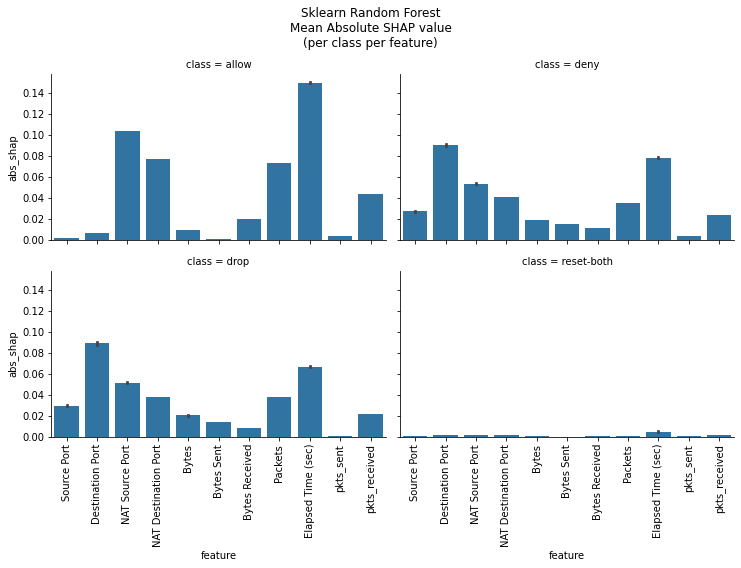

In [29]:
# for each feature, for each class - avg importance

slicer = slicer_skl
cls = cls_skl
shap_values = pd.DataFrame(np.concatenate([slicer.values[:,:,i]  for i in range(slicer.values.shape[-1])], axis=0), columns=X_test.columns)
shap_values['class'] = np.array(cls.classes_).repeat(slicer.values.shape[0])
shap_values['instance'] = np.tile(range(slicer.values.shape[0]), cls.n_classes_)
shap_values = shap_values.melt(id_vars=['class', 'instance'], var_name='feature', value_name='shap')
shap_values['abs_shap'] = np.abs(shap_values['shap'])

g = sns.FacetGrid(shap_values, col='class', col_wrap=2, height=4, aspect=1.3)
g.map_dataframe(sns.barplot, x='feature', y='abs_shap', estimator=np.mean)
g.set_xticklabels(rotation=90)
g.figure.suptitle('Sklearn Random Forest\nMean Absolute SHAP value\n(per class per feature)')
g.tight_layout()


# but wait...!!! the importances are almost totally different (even if logistic func is applied I imagine) between xgboost and sklearn random forrest!!



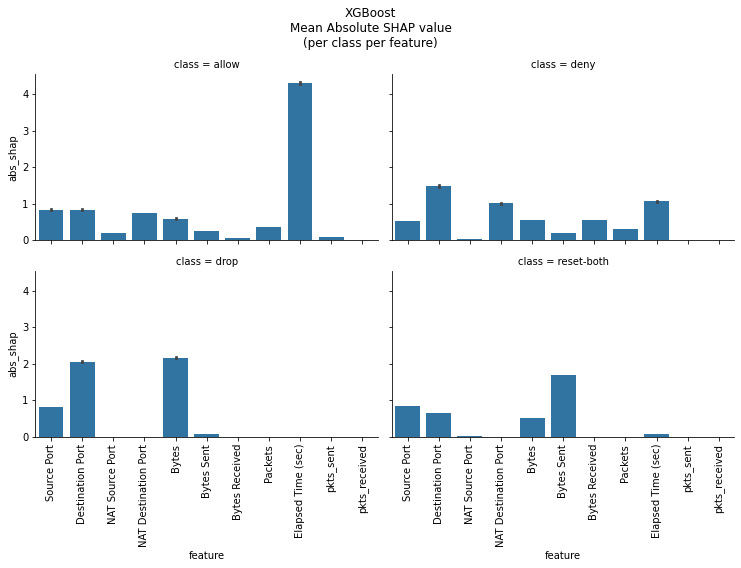

In [53]:
slicer = slicer_xgb
cls = cls_xgb

shap_values = pd.DataFrame(np.concatenate([slicer.values[:,:,i]  for i in range(slicer.values.shape[-1])], axis=0), columns=X_test.columns)
shap_values['class'] = np.array(cls.classes_).repeat(slicer.values.shape[0])
shap_values['instance'] = np.tile(range(slicer.values.shape[0]), cls.n_classes_)
shap_values = shap_values.melt(id_vars=['class', 'instance'], var_name='feature', value_name='shap')
shap_values['abs_shap'] = np.abs(shap_values['shap'])
shap_values['abs_shap_logistic'] = expit(shap_values['abs_shap']) # expit is symetric around 0, so transform after abs is fine

g = sns.FacetGrid(shap_values, col='class', col_wrap=2, height=4, aspect=1.3)
g.map_dataframe(sns.barplot, x='feature', y='abs_shap', estimator=np.mean)
g.set_xticklabels(rotation=90)
g.figure.suptitle('XGBoost\nMean Absolute SHAP value\n(per class per feature)')
g.tight_layout()

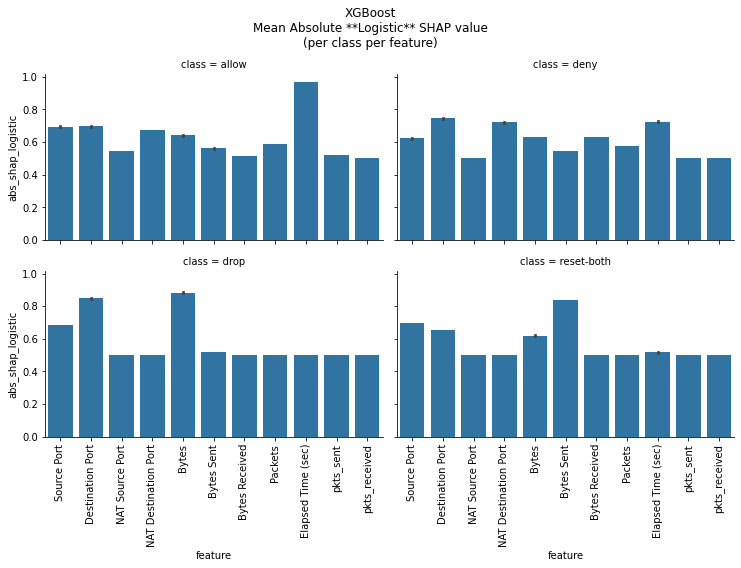

In [54]:
g = sns.FacetGrid(shap_values, col='class', col_wrap=2, height=4, aspect=1.3)
g.map_dataframe(sns.barplot, x='feature', y='abs_shap_logistic', estimator=np.mean)
g.set_xticklabels(rotation=90)
g.figure.suptitle('XGBoost\nMean Absolute **Logistic** SHAP value\n(per class per feature)')
g.tight_layout()

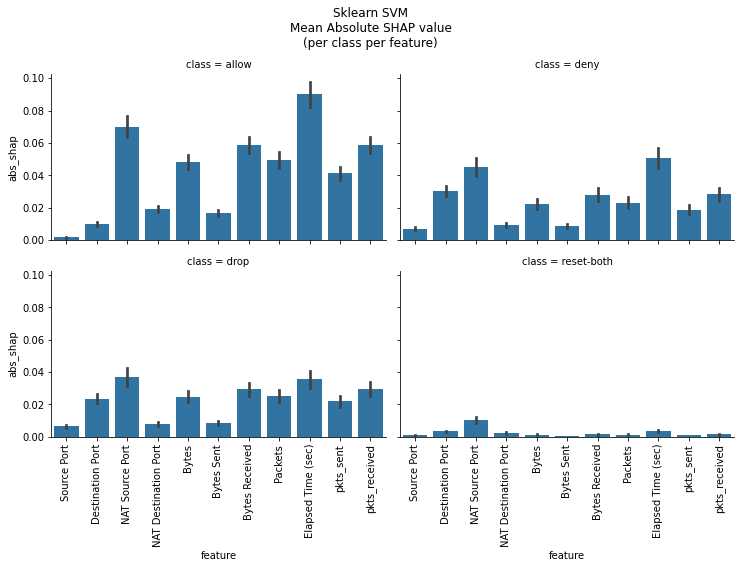

In [62]:
slicer = slicer_svm
cls = cls_svm

shap_values = pd.DataFrame(np.concatenate([slicer.values[:,:,i]  for i in range(slicer.values.shape[-1])], axis=0), columns=X_test.columns)
shap_values['class'] = np.array(cls.classes_).repeat(slicer.values.shape[0])
shap_values['instance'] = np.tile(range(slicer.values.shape[0]), cls['svc'].classes_.shape[0])
shap_values = shap_values.melt(id_vars=['class', 'instance'], var_name='feature', value_name='shap')
shap_values['abs_shap'] = np.abs(shap_values['shap'])

g = sns.FacetGrid(shap_values, col='class', col_wrap=2, height=4, aspect=1.3)
g.map_dataframe(sns.barplot, x='feature', y='abs_shap', estimator=np.mean)
g.set_xticklabels(rotation=90)
g.figure.suptitle('Sklearn SVM\nMean Absolute SHAP value\n(per class per feature)')
g.tight_layout()

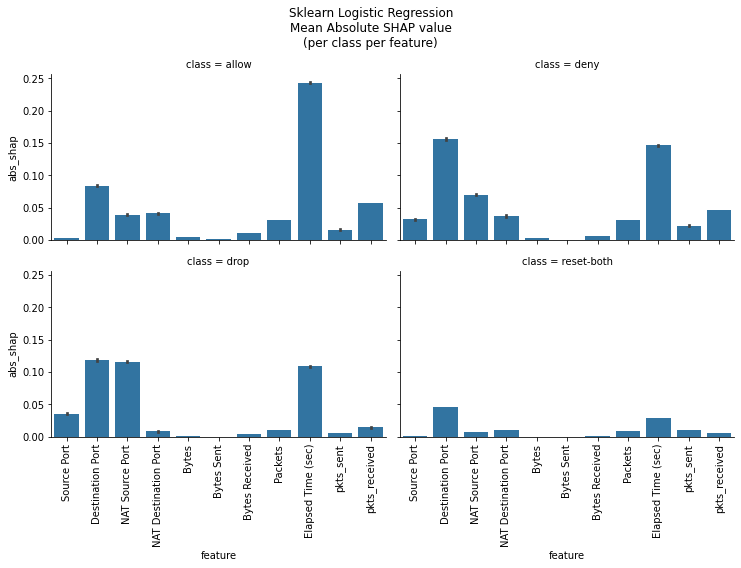

In [19]:
slicer = slicer_log
cls = cls_log

shap_values = pd.DataFrame(np.concatenate([slicer.values[:,:,i]  for i in range(slicer.values.shape[-1])], axis=0), columns=X_test.columns)
shap_values['class'] = np.array(cls.classes_).repeat(slicer.values.shape[0])
shap_values['instance'] = np.tile(range(slicer.values.shape[0]), cls['logisticregression'].classes_.shape[0])
shap_values = shap_values.melt(id_vars=['class', 'instance'], var_name='feature', value_name='shap')
shap_values['abs_shap'] = np.abs(shap_values['shap'])

g = sns.FacetGrid(shap_values, col='class', col_wrap=2, height=4, aspect=1.3)
g.map_dataframe(sns.barplot, x='feature', y='abs_shap', estimator=np.mean)
g.set_xticklabels(rotation=90)
g.figure.suptitle('Sklearn Logistic Regression\nMean Absolute SHAP value\n(per class per feature)')
g.tight_layout()


# ehhh. somewhere between XGBOOST and Random Forest

overflow encountered in exp


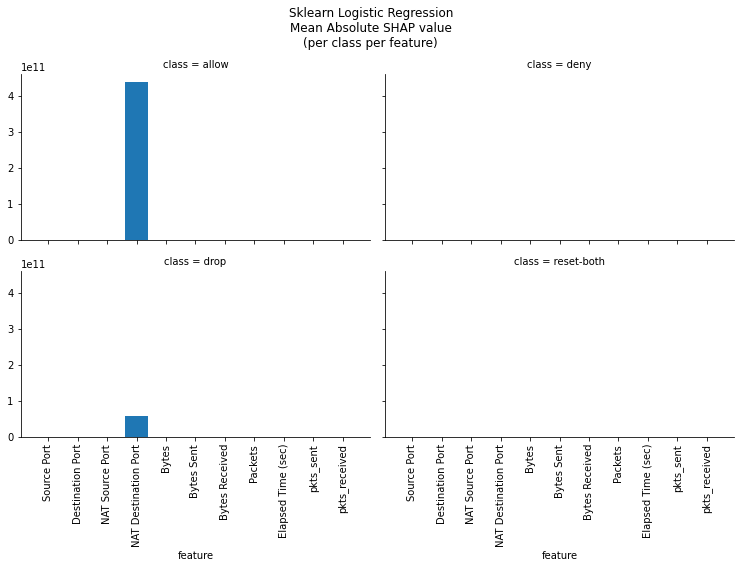

In [42]:
# logistic regression coeffcients (one-vs-rest per model)

coefs = pd.DataFrame(
    np.exp(cls_log['logisticregression'].coef_),
    index=cls_log['logisticregression'].classes_,
    columns = cls_log['standardscaler'].get_feature_names_out()
)
coefs = shap_values.unstack().reset_index()
coefs.columns = ['feature', 'class', 'coef']
# shap_values['abs_shap'] = np.abs(shap_values['shap'])


g = sns.FacetGrid(coefs, col='class', col_wrap=2, height=4, aspect=1.3)
g.map_dataframe(plt.bar, x='feature', height='coef',)
g.set_xticklabels(rotation=90)
g.figure.suptitle('Sklearn Logistic Regression\nMean Absolute SHAP value\n(per class per feature)')
g.tight_layout()

In [43]:
# multiclass permutation importance

In [58]:
# 

#TODO: Use Chi-sq to get measure of association between distributions
# - or could pair-wise correlation of feature importance across each model by pairs work too

4

**Discussion**  
The extremely high accuarcy here might be sysmptom of the same phenomenon that creates such varying feature importances by model type: highly separable data. The classes overall must be very highly separable, and as a result there maybe a wide range of decision boundaries that effectively separate teh classes. Different models settling on very different decision boundaries *maybe* causing differences in feature importances (and I say maybe bc I don't fully understand how the shap values are calculated.

[Text(0.5, 1.0, 'Mean Absolute SHAP value Across All Classes')]

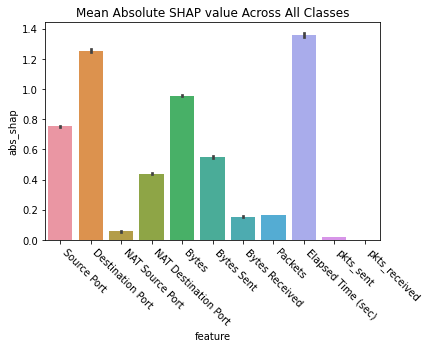

In [222]:
# mean absolute shap value across all classes

ax = sns.barplot( x='feature', y='abs_shap', estimator=np.mean, data=shap_values)
ax.set_xticklabels(ax.get_xticklabels(), ha='left',  rotation=-45)
ax.set(title='Mean Absolute SHAP value Across All Classes')

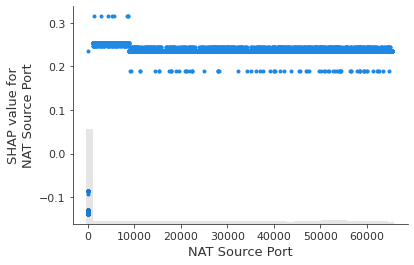

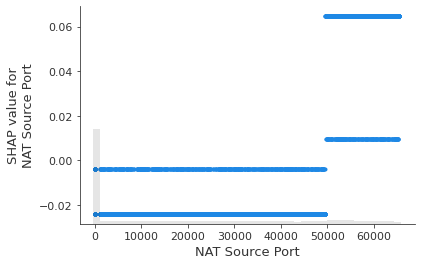

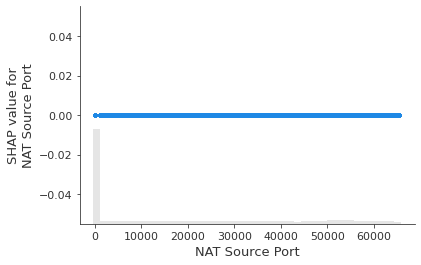

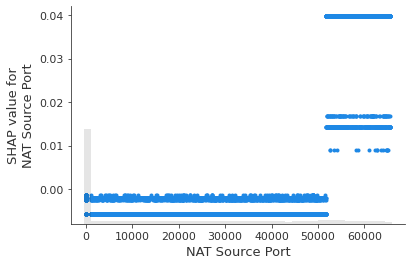

In [223]:
# Shap dependence plot for each class, for single feature

for i in range(len(cls.classes_)):
    fig, ax = plt.subplots()
    shap.plots.scatter(slicer[:,"NAT Source Port", i], ax=ax)
    ax.set(title=f'{cls.classes_[i]}')

